# Предсказание температуры нагрева сплава для металлургического комбината

**Описание проекта**

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Цель проекта**

Уменьшить потребление электроэнергии на этапе обработки стали.

**Задача**

Построить модель, которая предскажет температуру стали.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:
- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## План работы:

1. Провести предобработку
2. Обучить модели
3. Подобрать гиперпараметры
4. Протестировать лучшую модель

## Загрузка данных:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

from sklearn.utils import shuffle
from sklearn.inspection import permutation_importance

In [2]:
try:
    data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')
except:
    data_arc_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')

In [3]:
try:
    data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
except:
    data_bulk_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')

In [4]:
try:
    data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
except:
    data_bulk_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')

In [5]:
try:
    data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
except:
    data_gas_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')

In [6]:
try:
    data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
except:
    data_temp_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')

In [7]:
try:
    data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
except:
    data_wire_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')

In [8]:
try:
    data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')
except:
    data_wire_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

## Исследовательский анализ данных:

**data_arc_new:**

In [9]:
data_arc_new.info()
data_arc_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [10]:
data_arc_new.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [11]:
data_arc_new.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

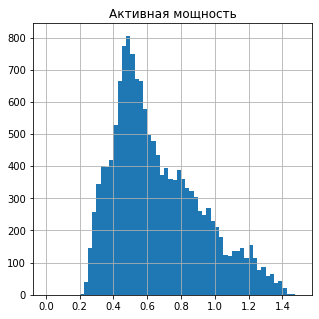

In [12]:
plt.figure(figsize=(5,5))
plt.hist(x=data_arc_new['Активная мощность'], bins=60, range=(0, 1.5))
plt.title('Активная мощность')
plt.grid(True)
plt.show()

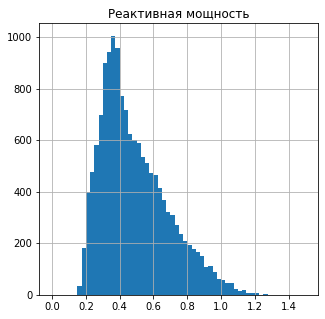

In [13]:
plt.figure(figsize=(5,5))
plt.hist(x=data_arc_new['Реактивная мощность'], bins=60, range=(0, 1.5))
plt.title('Реактивная мощность')
plt.grid(True)
plt.show()

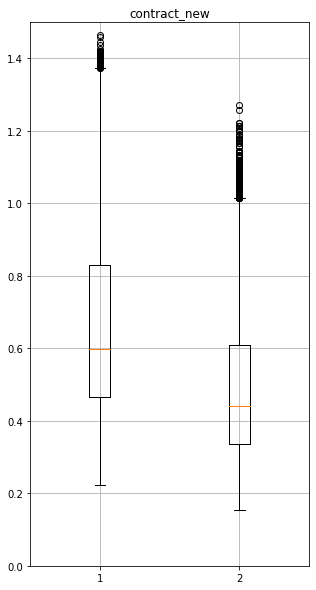

In [14]:
plt.figure(figsize=(5,10))
plt.boxplot(x=data_arc_new[['Активная мощность', 'Реактивная мощность']])
plt.title('contract_new')
plt.ylim(0, 1.5)
plt.grid(True)
plt.show()

**Посмотрим на процент выбросов:**

In [15]:
(1 - len(data_arc_new[data_arc_new['Активная мощность'] < 1.3])/len(data_arc_new))*100

1.5461145469212179

In [16]:
(1 - len(data_arc_new[data_arc_new['Реактивная мощность'] < 1])/len(data_arc_new))*100

1.5259478354396339

**Вывод:**

Распределение похоже на распределение Пуассона, процент выбросов допустимый

**data_bulk_new:**

In [17]:
data_bulk_new.info()
data_bulk_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


**Узнаем какой процент данных пропущен (NaN):**

In [18]:
data_bulk_new.isna().sum()/len(data_bulk_new)*100

key         0.000000
Bulk 1     91.946309
Bulk 2     99.296900
Bulk 3     58.517098
Bulk 4     67.593480
Bulk 5     97.539150
Bulk 6     81.591563
Bulk 7     99.201023
Bulk 8     99.968041
Bulk 9     99.392777
Bulk 10    94.375200
Bulk 11    94.343241
Bulk 12    21.700224
Bulk 13    99.424736
Bulk 14    10.322787
Bulk 15    28.155960
dtype: float64

**Вывод:**

Очень много пропусков

**data_bulk_time_new:**

In [19]:
data_bulk_time_new.info()
data_bulk_time_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


**Узнаем какой процент данных пропущен (NaN):**

In [20]:
data_bulk_time_new.isna().sum()/len(data_bulk_time_new)*100

key         0.000000
Bulk 1     91.946309
Bulk 2     99.296900
Bulk 3     58.517098
Bulk 4     67.593480
Bulk 5     97.539150
Bulk 6     81.591563
Bulk 7     99.201023
Bulk 8     99.968041
Bulk 9     99.392777
Bulk 10    94.375200
Bulk 11    94.343241
Bulk 12    21.700224
Bulk 13    99.424736
Bulk 14    10.322787
Bulk 15    28.155960
dtype: float64

**Вывод:**

Очень много пропусков

**data_gas_new:**

In [21]:
data_gas_new.info()
data_gas_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [22]:
data_gas_new.isna().sum()

key      0
Газ 1    0
dtype: int64

In [23]:
data_gas_new.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


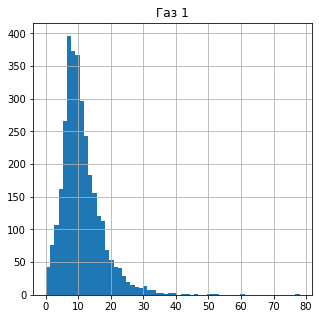

In [24]:
plt.figure(figsize=(5,5))
plt.hist(x=data_gas_new['Газ 1'], bins=60)
plt.title('Газ 1')
plt.grid(True)
plt.show()

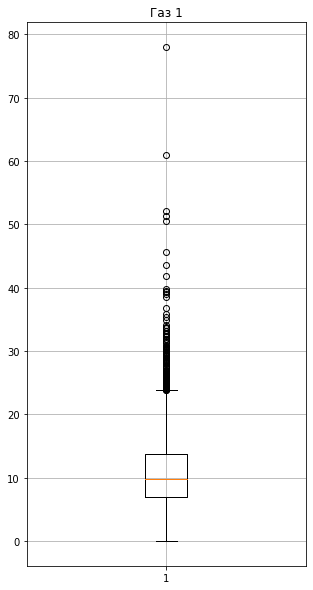

In [25]:
plt.figure(figsize=(5,10))
plt.boxplot(x=data_gas_new['Газ 1'])
plt.title('Газ 1')
plt.grid(True)
plt.show()

**Посмотрим на процент выбросов:**

In [26]:
(1 - len(data_gas_new[data_gas_new['Газ 1'] < 23])/len(data_gas_new))*100

4.3531954306884835

**Вывод:**

Распределение похоже на распределение Пуассона, процент выбросов допустимый

**data_temp_new:**

In [27]:
data_temp_new.info()
data_temp_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [28]:
data_temp_new.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


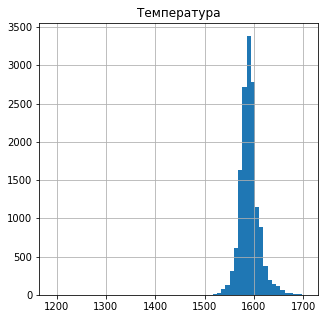

In [29]:
plt.figure(figsize=(5,5))
plt.hist(x=data_temp_new['Температура'], bins=60)
plt.title('Температура')
plt.grid(True)
plt.show()

**Количество пропусков (NaN) в %:**

In [30]:
data_temp_new.isna().sum()/len(data_temp_new)*100

key              0.000000
Время замера     0.000000
Температура     18.942074
dtype: float64

<AxesSubplot:>

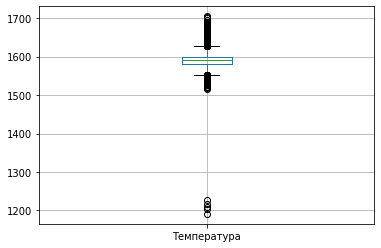

In [31]:
data_temp_new.boxplot('Температура')

**Вывод:**

Очень много пропусков, требуется консультация тимлида

**data_wire_new:**

In [32]:
data_wire_new.info()
data_wire_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
data_wire_new.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [34]:
data_wire_new.isna().sum()/len(data_wire_new)*100

key        0.000000
Wire 1     0.843882
Wire 2    64.978903
Wire 3    97.955209
Wire 4    99.545602
Wire 5    99.967543
Wire 6    97.630639
Wire 7    99.642973
Wire 8    99.383317
Wire 9    99.058747
dtype: float64

**Вывод:**

Очень много пропусков

**data_wire_time_new:**

In [35]:
data_wire_time_new.info()
data_wire_time_new.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
data_wire_time_new.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [37]:
data_wire_time_new.isna().sum()/len(data_wire_time_new)*100

key        0.000000
Wire 1     0.843882
Wire 2    64.978903
Wire 3    97.955209
Wire 4    99.545602
Wire 5    99.967543
Wire 6    97.630639
Wire 7    99.642973
Wire 8    99.383317
Wire 9    99.058747
dtype: float64

**Вывод:**

Очень много пропусков

### Общий вывод:
Готовыми к использованию выглядят только данные в таблицах data_arc_new, data_gas_new: в них нет пропусков и процент выбросов допустимый. Остальные таблицы требуют предобработки данных: заполнения пропусков и фильтрации выбросов.

## Предобработка данных

Пересчет активной и реактивной мощности на полную мощность
Активная составляющая - потребляемой любой нагрузкой мощности электрического тока совершает полезную работу и трансформируется в нужные нам виды энергии (тепловую, световую, звуковую и т.п.).
Реактивная составляющая электрического тока возникает только в цепях, содержащих реактивные элементы (индуктивности и ёмкости) и расходуется обычно на бесполезный нагрев проводников, из которых составлена эта цепь. Примером таких реактивных нагрузок являются электродвигатели различного типа, переносные электроинструменты (электродрели, «болгарки», штроборезы и т.п.), а также различная бытовая электронная техника.
Для расчетов температуры необходимо использовать значения полной мощности. S = sqrt(P^2+Q^2)

In [38]:
display(data_arc_new.head())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [39]:
data_arc_new['full_power']=(data_arc_new['Активная мощность']**2+data_arc_new['Реактивная мощность']**2)**0.5
display(data_arc_new.head(3))

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536


### Расчет времени нагрева

- Электрическая энергия тратится когда ток протекает через электрод, значит следует выделить длительность работы электрода

In [40]:
data_arc_new['Конец нагрева дугой']=data_arc_new['Конец нагрева дугой'].astype('datetime64[s]')
data_arc_new['Начало нагрева дугой']=data_arc_new['Начало нагрева дугой'].astype('datetime64[s]')

In [41]:
data_arc_new['heating_time']=data_arc_new['Конец нагрева дугой'] - data_arc_new['Начало нагрева дугой']
data_arc_new['heating_time'] = data_arc_new['heating_time'].dt.seconds
display(data_arc_new.head(3))

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,full_power,heating_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172


In [42]:
data_arc_new = data_arc_new.drop(columns=['Начало нагрева дугой','Конец нагрева дугой'], axis=1)
display(data_arc_new.head(3))

,key,Активная мощность,Реактивная мощность,full_power,heating_time
0,1,0.305130,0.211253,0.371123,228
1,1,0.765658,0.477438,0.902319,185
2,1,0.580313,0.430460,0.722536,172


#### Итерации обработки

- В условии сказано, что `key` может повторяться - это означает разные итерации обработки: одна и та же партия металла нагревается больше одного раза. сгруппируем эти данные

In [43]:
heating_run=data_arc_new['key'].value_counts().reset_index(name='heating_rounds').rename(columns={'index': 'key'})
heating_run.head()

,key,heating_rounds
0,2108,16
1,1689,15
2,1513,15
3,2567,14
4,46,13


#### Переименование столбцов

- Приведем столбцы к единому виду

In [44]:
data_arc_new = data_arc_new.rename(columns={'Активная мощность': "active_power",'Реактивная мощность': "reactive_power"})
display(data_arc_new.head(3))

,key,active_power,reactive_power,full_power,heating_time
0,1,0.305130,0.211253,0.371123,228
1,1,0.765658,0.477438,0.902319,185
2,1,0.580313,0.430460,0.722536,172


#### Проверка на выбросы - мощность

<AxesSubplot:>

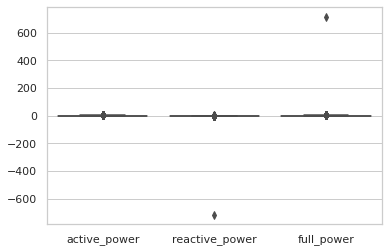

In [45]:
sns.set(style='whitegrid')
sns.boxplot(data=data_arc_new[['active_power', 'reactive_power', 'full_power']])

In [46]:
data_arc_new=data_arc_new.query('reactive_power >= 0')

- Изначальные значения мощности больше не нужны

In [47]:
data_arc_new = data_arc_new.drop(columns=['active_power','reactive_power'], axis=1)

#### Проверка на выбросы - время

<AxesSubplot:>

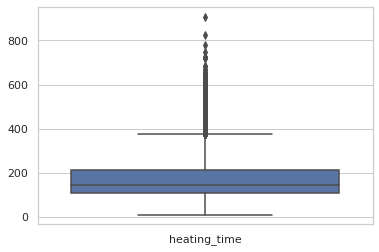

In [48]:
sns.boxplot(data=data_arc_new[['heating_time']])

- По времени есть очень большие значения, но они не выглядят как выбросы, можно представить себе нагрев в течении 800 сек

#### Группировка данных для партий, которые нагреваются более однго раза

In [49]:
data_arc_new_grouped=data_arc_new.groupby(by = 'key').sum()
data_arc_new_grouped = data_arc_new_grouped.merge(heating_run, on='key')
data_arc_new_grouped.head(5)

,key,full_power,heating_time,heating_rounds
0,1,3.718736,1098,5
1,2,2.588349,811,4
2,3,5.019223,655,5
3,4,3.400038,741,4
4,5,2.816980,869,4


### Данные о подаче сыпучих материалов (объём)

In [50]:
display(data_bulk_new.head(3))

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0


#### Обработка пропусков

In [51]:
data_bulk_new=data_bulk_new.fillna(0)

In [52]:
counter_1 = (((data_bulk_new == 0).sum()/data_bulk_new.shape[0])*100).sort_values()
display(counter_1)

key         0.000000
Bulk 14    10.322787
Bulk 12    21.700224
Bulk 15    28.155960
Bulk 3     58.517098
Bulk 4     67.593480
Bulk 6     81.591563
Bulk 1     91.946309
Bulk 11    94.343241
Bulk 10    94.375200
Bulk 5     97.539150
Bulk 7     99.201023
Bulk 2     99.296900
Bulk 9     99.392777
Bulk 13    99.424736
Bulk 8     99.968041
dtype: float64

In [53]:
data_bulk_new=data_bulk_new[['key','Bulk 14','Bulk 12','Bulk 15','Bulk 3','Bulk 4']]
data_bulk_new

,key,Bulk 14,Bulk 12,Bulk 15,Bulk 3,Bulk 4
0,1,150.0,206.0,154.0,0.0,43.0
1,2,149.0,206.0,154.0,0.0,73.0
2,3,152.0,205.0,153.0,0.0,34.0
3,4,153.0,207.0,154.0,0.0,81.0
4,5,151.0,203.0,152.0,0.0,78.0
...,...,...,...,...,...,...
3124,3237,130.0,252.0,206.0,170.0,0.0
3125,3238,108.0,254.0,106.0,126.0,0.0
3126,3239,270.0,158.0,88.0,0.0,0.0
3127,3240,192.0,0.0,54.0,0.0,0.0


### Данные о продувке сплава газом

#### Переименование столбцов

In [54]:
data_gas_new = data_gas_new.rename(columns={'Газ 1': "gas_1"})
display(data_gas_new.head(3))

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793


### Результаты измерения температуры

#### Переименование столбцов

In [55]:
data_temp_new = data_temp_new.rename(columns={'Время замера': "measure_time",'Температура': "temperature",})
display(data_temp_new.head(3))

,key,measure_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0


In [56]:
counter_2=data_temp_new.isna().sum()/data_temp_new.shape[0]*100
counter_2

key              0.000000
measure_time     0.000000
temperature     18.942074
dtype: float64

- 19 процентов пропусков - значительная доля, но их никак нельзя восстановить - удалим их

In [57]:
data_temp_new=data_temp_new.dropna()

#### Проверка на выбросы

<AxesSubplot:>

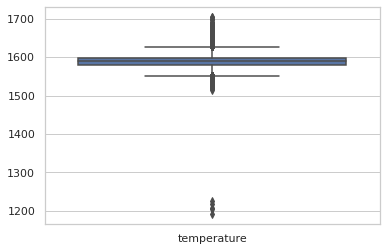

In [58]:
sns.set(style='whitegrid')
sns.boxplot(data=data_temp_new[['temperature']])

- По условию удалим значения менее 1500

In [59]:
data_temp_new = data_temp_new[data_temp_new['temperature'] > 1500]

#### Итерации измерений

- Температура должна измеряться более одного раза - в этом смысл контроля процесса нагрева
- Последнее измерение температуры должно соотвествовать окончанию нагрева и выключению электродов
- Для анализа потраченной энергии нужно знать величину на сколько нагрелся материал - разницу между первым и последним замером температуры

In [60]:
measure_run = data_temp_new['key'].value_counts().\
reset_index(name='measure_run').rename(columns={'index': 'key'})
display(measure_run)

,key,measure_run
0,2108,17
1,1513,16
2,1689,16
3,46,14
4,322,14
...,...,...
3210,3236,1
3211,2963,1
3212,2955,1
3213,2947,1


In [61]:
data_temp_grouped = data_temp_new.groupby(by = 'key').agg(['first', 'last']).reset_index()
data_temp_grouped.columns = ['key', 'init_temp_time', 'finish_temp_time', 'init_temp', 'finish_temp']
data_temp_grouped['init_temp_time']=data_temp_grouped['init_temp_time'].astype('datetime64[s]')
data_temp_grouped['finish_temp_time']=data_temp_grouped['finish_temp_time'].astype('datetime64[s]')
data_temp_grouped['temp_measure_interval'] = data_temp_grouped['finish_temp_time'] - data_temp_grouped['init_temp_time']
data_temp_grouped['temp_measure_interval'] = data_temp_grouped['temp_measure_interval'].dt.seconds
data_temp_grouped=data_temp_grouped.query('temp_measure_interval>0')
data_temp_grouped

,key,init_temp_time,finish_temp_time,init_temp,finish_temp,temp_measure_interval
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,1714
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,1265
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,1753
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,1220
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,1536
...,...,...,...,...,...,...
2472,2495,2019-08-10 11:27:47,2019-08-10 11:50:47,1570.0,1591.0,1380
2473,2496,2019-08-10 11:56:48,2019-08-10 12:25:13,1554.0,1591.0,1705
2474,2497,2019-08-10 12:37:26,2019-08-10 12:53:28,1571.0,1589.0,962
2475,2498,2019-08-10 12:58:11,2019-08-10 13:23:31,1591.0,1594.0,1520


### Данные о проволочных материалах (объём)

- Обработаем датасет аналогично датасету о сыпучих материалах

In [62]:
data_wire_new=data_wire_new.fillna(0)

In [63]:
counter_3 = (((data_wire_new == 0).sum()/data_wire_new.shape[0])*100).sort_values()
display(counter_3)

key        0.000000
Wire 1     0.843882
Wire 2    64.978903
Wire 6    97.630639
Wire 3    97.955209
Wire 9    99.058747
Wire 8    99.383317
Wire 4    99.545602
Wire 7    99.642973
Wire 5    99.967543
dtype: float64

In [64]:
data_wire_new=data_wire_new[['key','Wire 1','Wire 2']]
data_wire_new.head()

,key,Wire 1,Wire 2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456


### Объединение

In [65]:
df = data_arc_new_grouped.merge(data_bulk_new, on='key',how='inner')
df = df.merge(data_gas_new, on='key',how='inner')
df = df.merge(data_temp_grouped, on='key',how='inner')
df = df.merge(data_wire_new, on='key',how='inner')
df.head()

,key,full_power,heating_time,heating_rounds,Bulk 14,Bulk 12,Bulk 15,Bulk 3,Bulk 4,gas_1,init_temp_time,finish_temp_time,init_temp,finish_temp,temp_measure_interval,Wire 1,Wire 2
0,1,3.718736,1098,5,150.0,206.0,154.0,0.0,43.0,29.749986,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,1714,60.059998,0.00000
1,2,2.588349,811,4,149.0,206.0,154.0,0.0,73.0,12.555561,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,1265,96.052315,0.00000
2,3,5.019223,655,5,152.0,205.0,153.0,0.0,34.0,28.554793,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,1753,91.160157,0.00000
3,4,3.400038,741,4,153.0,207.0,154.0,0.0,81.0,18.841219,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,1220,89.063515,0.00000
4,5,2.816980,869,4,151.0,203.0,152.0,0.0,78.0,5.413692,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,1536,89.238236,9.11456


### Удаление лишних признаков

- Мы уже вычислили время между измерениями температуры, удалим столбцы с первым и последним измерением
- Мы уже соединили таблицы, индекс `key` больше не нужен

In [66]:
df = df.drop(columns=['key','init_temp_time','finish_temp_time'], axis=1)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   full_power             2329 non-null   float64
 1   heating_time           2329 non-null   int64  
 2   heating_rounds         2329 non-null   int64  
 3   Bulk 14                2329 non-null   float64
 4   Bulk 12                2329 non-null   float64
 5   Bulk 15                2329 non-null   float64
 6   Bulk 3                 2329 non-null   float64
 7   Bulk 4                 2329 non-null   float64
 8   gas_1                  2329 non-null   float64
 9   init_temp              2329 non-null   float64
 10  finish_temp            2329 non-null   float64
 11  temp_measure_interval  2329 non-null   int64  
 12  Wire 1                 2329 non-null   float64
 13  Wire 2                 2329 non-null   float64
dtypes: float64(11), int64(3)
memory usage: 272.9 KB


#### Выводы

- Входные данные очищены, подготовлены, проверены на пропуски и дубликаты
- Обработаны выбросы
- Произведены вспомогательные вычисления (полная мощность, время между измерениями)
- Удалены лишние столбцы
- Использованы только данные, которые влияют на процесс нагрева

### Подготовка данных и обучение моделей

In [68]:
df.describe()
df.head(3)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   full_power             2329 non-null   float64
 1   heating_time           2329 non-null   int64  
 2   heating_rounds         2329 non-null   int64  
 3   Bulk 14                2329 non-null   float64
 4   Bulk 12                2329 non-null   float64
 5   Bulk 15                2329 non-null   float64
 6   Bulk 3                 2329 non-null   float64
 7   Bulk 4                 2329 non-null   float64
 8   gas_1                  2329 non-null   float64
 9   init_temp              2329 non-null   float64
 10  finish_temp            2329 non-null   float64
 11  temp_measure_interval  2329 non-null   int64  
 12  Wire 1                 2329 non-null   float64
 13  Wire 2                 2329 non-null   float64
dtypes: float64(11), int64(3)
memory usage: 272.9 KB


- Приведем данные в некоторых столбцах к более подходящим типам

In [69]:
df['Bulk 14']=df['Bulk 14'].astype('int32')
df['Bulk 12']=df['Bulk 12'].astype('int32')
df['Bulk 15']=df['Bulk 15'].astype('int32')
df['Bulk 3']=df['Bulk 3'].astype('int32')
df['Bulk 4']=df['Bulk 4'].astype('int32')
df['init_temp']=df['init_temp'].astype('int32')
df['finish_temp']=df['finish_temp'].astype('int32')

**Оценка корреляции, мультиколлинеарности, зависимости целевого признака от прочих признаков**

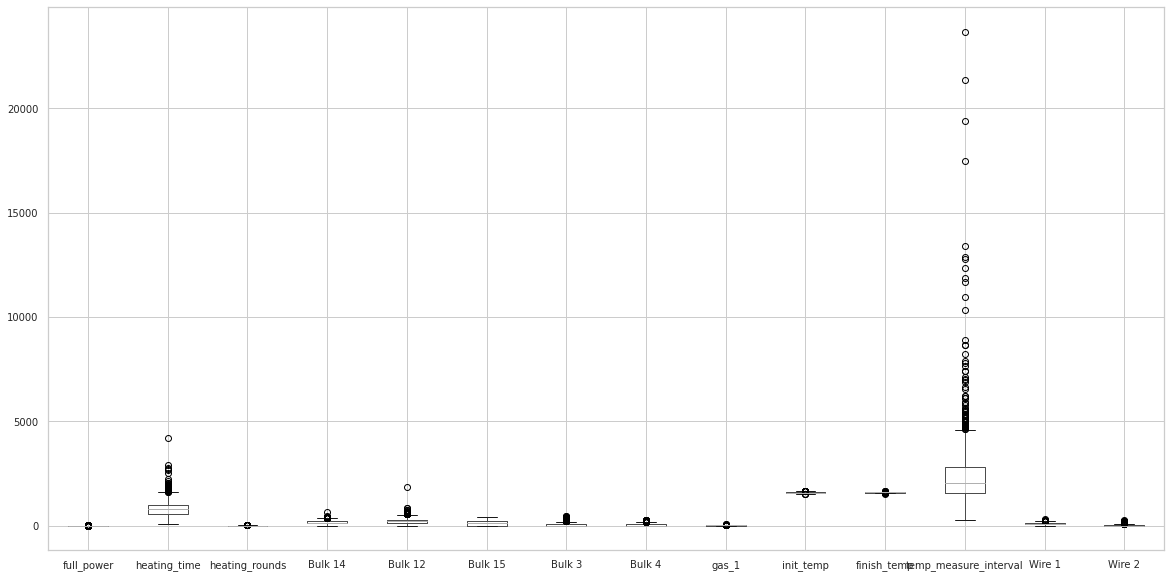

In [70]:
df.boxplot(figsize=(20,10),fontsize=10)
plt.show()

In [71]:
df['temp_measure_interval'].describe()

count     2329.000000
mean      2321.810219
std       1385.191527
min        270.000000
25%       1579.000000
50%       2045.000000
75%       2791.000000
max      23674.000000
Name: temp_measure_interval, dtype: float64

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   full_power             2329 non-null   float64
 1   heating_time           2329 non-null   int64  
 2   heating_rounds         2329 non-null   int64  
 3   Bulk 14                2329 non-null   int32  
 4   Bulk 12                2329 non-null   int32  
 5   Bulk 15                2329 non-null   int32  
 6   Bulk 3                 2329 non-null   int32  
 7   Bulk 4                 2329 non-null   int32  
 8   gas_1                  2329 non-null   float64
 9   init_temp              2329 non-null   int32  
 10  finish_temp            2329 non-null   int32  
 11  temp_measure_interval  2329 non-null   int64  
 12  Wire 1                 2329 non-null   float64
 13  Wire 2                 2329 non-null   float64
dtypes: float64(4), int32(7), int64(3)
memory usage: 209.2 KB

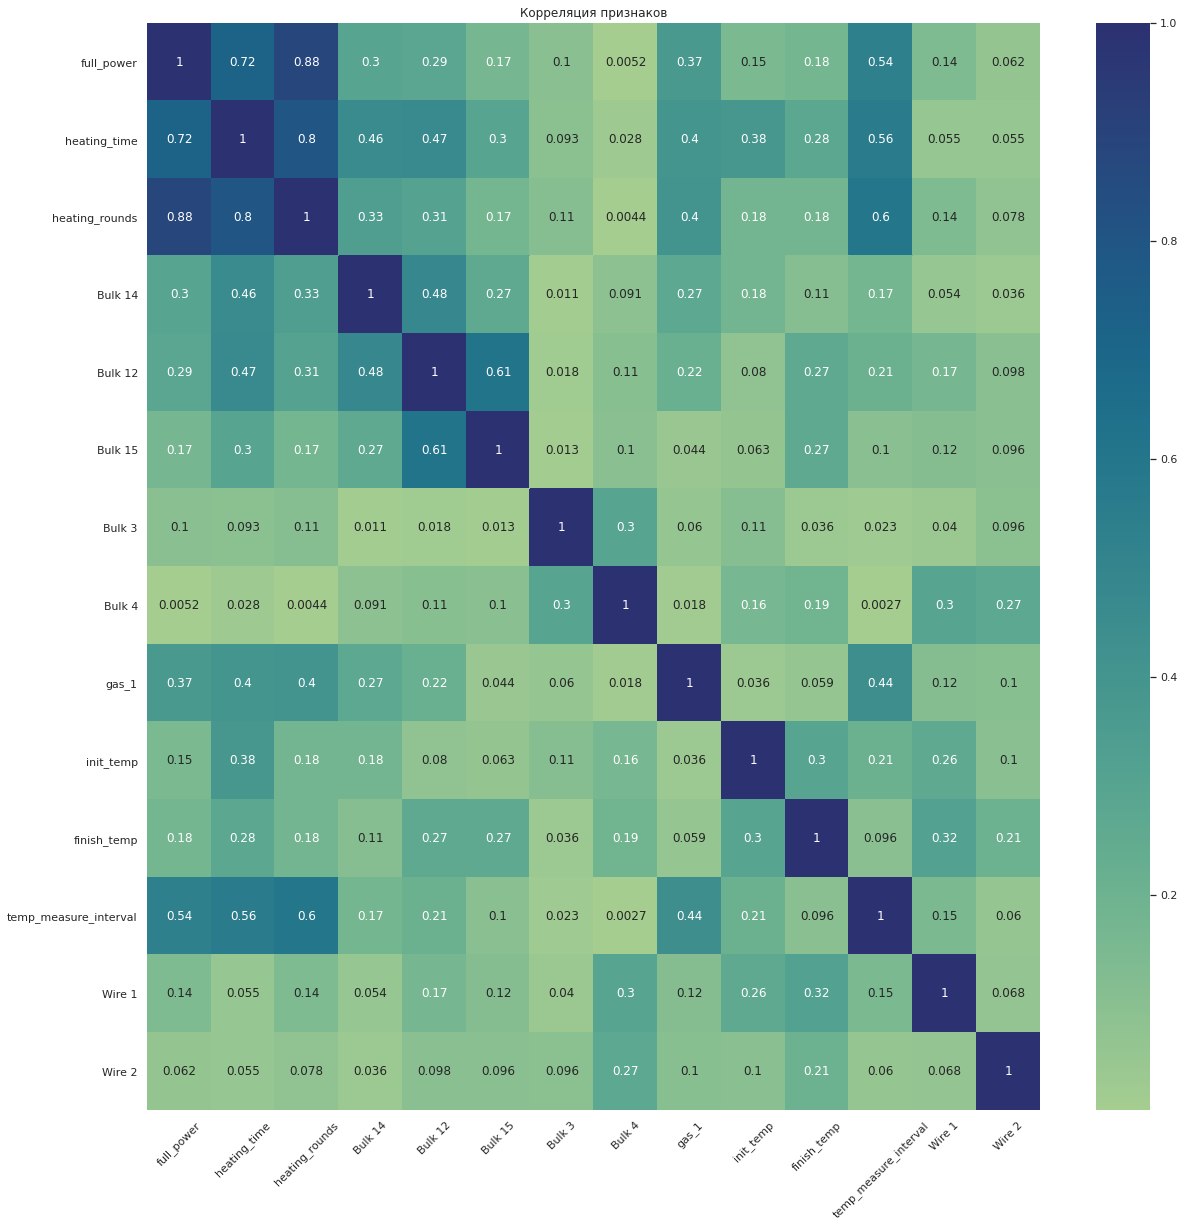

In [74]:
df_corr=df.corr()

plt.figure(figsize=(20, 20))
fig = sns.heatmap(df_corr.abs(), cmap='crest', annot=True)
plt.title('Корреляция признаков', fontsize=12)
plt.setp(fig.get_xticklabels(), rotation=45)
plt.show()

- Из heatmap видно, что признаки `heating_rounds`,`heating_time` сильно коррелируют - пробовал удалить из модели, но результаты значительно ухудщились, поэтому лучше их оставить
- Остальные признаки коррелируют не насколько сильно, не будем их трогать

In [75]:
display(df_corr.corr()['finish_temp'])

full_power              -0.052964
heating_time             0.016351
heating_rounds          -0.062853
Bulk 14                 -0.060115
Bulk 12                  0.237716
Bulk 15                  0.300916
Bulk 3                  -0.332332
Bulk 4                   0.341688
gas_1                   -0.238539
init_temp                0.328460
finish_temp              1.000000
temp_measure_interval   -0.113074
Wire 1                   0.402397
Wire 2                  -0.629474
Name: finish_temp, dtype: float64

- Наибольшее влияние на целевой признак оказывают следующие признаки: `Wire 2 `,`Wire 1`,`Bulk 12`,`Bulk 15`, `heating_time`
- Можно предположить что это означает введение в партию тугоплавких или, наоборот, легкоплавких добавок, которые оказывают сильное влияние на температуру

**Зафиксируем RANDOM STATE**

In [76]:
RANDOM_STATE = 280823

**Выделим целевый признак**

In [77]:
features = df.drop(columns='finish_temp')
target = df['finish_temp']

**Разделим выборки на обучающую и тестовую В пропорции 3:1**

In [78]:
features_train, features_test, target_train, target_test = train_test_split(features, target, \
                                        test_size=0.25, random_state=RANDOM_STATE, shuffle=True)

**Удалим выбросы ('temp_measure_interval <= 5000')**

In [79]:
len(features_train)

1746

In [80]:
len(target_train)

1746

In [81]:
train = pd.concat([features_train, target_train], axis=1)

In [82]:
train.head()

,full_power,heating_time,heating_rounds,Bulk 14,Bulk 12,Bulk 15,Bulk 3,Bulk 4,gas_1,init_temp,temp_measure_interval,Wire 1,Wire 2,finish_temp
67,5.044587,1216,6,215,408,203,146,0,11.024942,1605,2958,110.292000,45.135998,1604
2221,5.604434,1056,8,179,125,104,0,0,11.743407,1580,2992,50.974560,75.400001,1589
484,0.505416,241,1,255,106,0,0,0,4.247358,1596,5471,0.000000,22.107281,1581
1735,2.125972,614,3,199,0,0,0,0,6.080227,1585,1428,101.649598,0.000000,1585
116,4.556028,1023,6,254,512,201,349,0,7.017192,1579,3255,124.225914,0.000000,1581


In [83]:
train=train.query('temp_measure_interval <= 5000')

In [84]:
features_train = train.drop(columns='finish_temp')

In [85]:
target_train = train['finish_temp']

In [86]:
len(features_train)

1702

In [87]:
len(target_train)

1702

In [88]:
len(features_test)

583

In [89]:
len(target_test)

583

## Выбор модели

### RandomForestRegression

In [90]:
param_grid = {'n_estimators':[100,125,150],
              'max_depth': [10,15,20],
              'random_state':[RANDOM_STATE]}

rand_forest_model = RandomForestRegressor()
                                  
param_rand_forest = GridSearchCV(estimator = rand_forest_model,\
                                  param_grid = param_grid,\
                                  scoring= 'neg_mean_absolute_error',\
                                  cv=5)

param_rand_forest.fit(features_train, target_train)
print('best params\n', param_rand_forest.best_params_)
print('best MSE\n', -param_rand_forest.best_score_)

best params
 {'max_depth': 20, 'n_estimators': 100, 'random_state': 280823}
best MSE
 5.948254322883431


### LinearRegression

#### Отмасштабируем признаки обучающей выборки

In [91]:
scaler = StandardScaler()

scaler_features_train = scaler.fit_transform(features_train)
scaler_features_train_df = pd.DataFrame(scaler_features_train, columns=features_train.columns)
#check
scaler_features_train_df.head()

,full_power,heating_time,heating_rounds,Bulk 14,Bulk 12,Bulk 15,Bulk 3,Bulk 4,gas_1,init_temp,temp_measure_interval,Wire 1,Wire 2
0,0.852672,1.379598,0.921319,0.817644,1.333380,0.992800,1.325726,-0.653109,-0.016792,0.737442,0.896789,0.157957,0.856732
1,1.249326,0.862636,2.273116,0.360168,-0.521637,-0.177097,-0.632837,-0.653109,0.104263,-0.330496,0.936588,-1.217367,1.783808
2,-1.215185,-0.565471,-1.106377,0.614321,-1.340990,-1.406081,-0.632837,-0.653109,-0.849932,-0.116908,-0.894157,-0.042424,-0.525916
3,0.506525,0.756013,0.921319,1.313243,2.015082,0.969166,4.048934,-0.653109,-0.692062,-0.373214,1.244443,0.481027,-0.525916
4,-0.449491,0.161507,0.245420,0.665152,1.798773,-1.406081,-0.632837,1.648672,-0.695576,0.865594,0.455491,0.711719,-0.525916


#### Отмасштабируем признаки тестовой выборки

In [92]:
scaler_features_test = scaler.transform(features_test)
scaler_features_test_df = pd.DataFrame(scaler_features_test, columns=features_test.columns)
#check
scaler_features_test_df.head()

,full_power,heating_time,heating_rounds,Bulk 14,Bulk 12,Bulk 15,Bulk 3,Bulk 4,gas_1,init_temp,temp_measure_interval,Wire 1,Wire 2
0,-0.698520,0.788323,0.245420,-0.618323,0.009305,-0.188915,-0.632837,3.391932,-0.455075,-1.526586,-0.617906,-0.169380,-0.525916
1,0.849919,1.256820,0.921319,-1.914505,-1.340990,-1.406081,1.433045,0.785504,-0.503410,-1.184846,-0.274934,-0.562186,-0.525916
2,-0.141258,-0.507312,-0.430478,-0.402293,0.337046,1.016434,-0.123074,0.142360,-1.061027,-0.629519,-0.956196,0.501209,-0.525916
3,0.294366,1.327902,-0.430478,0.601613,3.037636,1.016434,1.339141,-0.653109,-1.232925,-1.782892,-0.063064,-0.077147,-0.525916
4,-1.396671,0.132428,-1.106377,1.986749,1.339935,0.354674,-0.632837,-0.653109,0.809936,0.267549,0.120713,-0.909417,0.213195


#### Обучение Linear Regression

In [93]:
linear_regression_model = LinearRegression()
linear_param_grid = {}
linear_grid_search = GridSearchCV(linear_regression_model, linear_param_grid, cv=5, n_jobs=-1, verbose=10, scoring='neg_mean_absolute_error')
grid_lr = linear_grid_search.fit(scaler_features_train_df, target_train)
print('Лучший результат для линейной регрессии:', -linear_grid_search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START ............................................................
[CV 1/5; 1/1] END ........................................... total time=   0.0s
[CV 2/5; 1/1] START ............................................................
[CV 2/5; 1/1] END ........................................... total time=   0.0s
[CV 3/5; 1/1] START ............................................................
[CV 3/5; 1/1] END ........................................... total time=   0.0s
[CV 4/5; 1/1] START ............................................................
[CV 4/5; 1/1] END ........................................... total time=   0.1s
[CV 5/5; 1/1] START ............................................................
[CV 5/5; 1/1] END ........................................... total time=   0.0s
Лучший результат для линейной регрессии: 5.878494068631046


#### Вывод:
- Лучший результат показывает модель линейной регрессии

### Тестирование лучшей модели (LinearRegression):

In [94]:
predictions = grid_lr.best_estimator_.predict(scaler_features_test_df)

mae = mean_absolute_error(target_test, predictions)

print('Средняя абсолютная ошибка на тестовой выборке:', mae)

Средняя абсолютная ошибка на тестовой выборке: 5.977768893298465


### Исследование важности признаков

MAE (test): 5.977768893298465


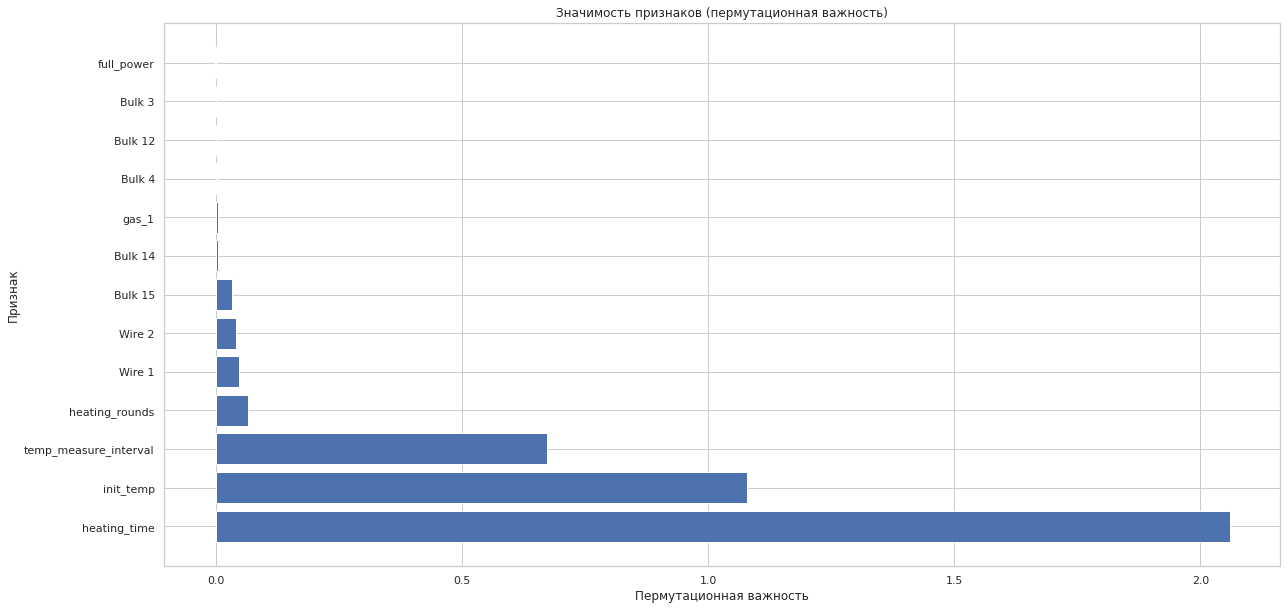

In [95]:
linear_regression_model = LinearRegression(n_jobs=-1)
linear_regression_model.fit(scaler_features_train_df, target_train)
predictions = linear_regression_model.predict(scaler_features_test_df)
mae = mean_absolute_error(target_test, predictions)
print(f'MAE (test):',mae)

perm_importance = permutation_importance(linear_regression_model, scaler_features_test_df, target_test, n_repeats=30, random_state=0)

plot = {
    'features': scaler_features_test_df.columns,
    'permutation_importance': perm_importance.importances_mean,
}

plot = pd.DataFrame(plot)
plot.sort_values(by='permutation_importance', ascending=False, inplace=True)

plt.figure(figsize=(20, 10))
plt.barh(plot['features'], plot['permutation_importance'])
plt.title('Значимость признаков (пермутационная важность)', fontsize=12)
plt.xlabel('Пермутационная важность')
plt.ylabel('Признак')
plt.show()

#### Вывод по важности признаков:

Наиболее важны три признака, перечислим их в порядке убывания важности:
- Время нагрева 'heating time'
- Начальная температура нагрева 'init_temp'
- Интервал измерения температур 'temp_measure_interval'

# Сравнение с константной моделью

In [96]:
dummy_model = DummyRegressor(strategy="mean")

dummy_model.fit(features_train, target_train)

dummy_predictions = dummy_model.predict(features_test)

mae_dummy = mean_absolute_error(target_test, dummy_predictions)

print('MAE для константной модели (предсказание среднего значения):', mae_dummy)
print('MAE для лучшей модели (Линейная регрессия):', -linear_grid_search.best_score_)

MAE для константной модели (предсказание среднего значения): 8.284607151711329
MAE для лучшей модели (Линейная регрессия): 5.878494068631046


## Итоговый вывод

- Переделал этап предобработки, нашел ошибки, это позволило добиться целевых показателей MAE

- Для повышения точности прогноза добавлены новые признаки, выведенные из старых

- Признаки для линейной регрессии отмасштабированы

- Модель линейной регрессии показала себя лучшей

- МAE константной модели значительно ниже - проверка на адекватность пройдена

Наиболее важные признаки: 
- Время нагрева 'heating time'
- Начальная температура нагрева 'init_temp'
- Интервал измерения температур 'temp_measure_interval'

### Отчёт

- **Все запланированные пункты плана выполнены**
    
    - Были загружены исходные данные, проведена их обработка и исследовательский анализ
    - Все таблицы загружены
    - Все имена столбцов приведены к единому виду
    - Таблицы о времени загрузки сыпучих и проволочных материалов - не используются
    - Все таблицы объединены
    - После объединения итоговая таблица еще раз исследована, проверена корреляция, удалены выбросы
    - Удалены лишние признаки (индексы, столбцы с абсолютными значениями времени)
    - Выделен целевой признак
    - Разделены выборки
    - Удалены выбросы
    - Обучены модели, найдена лучшая модель и протестирована на тестовой выборке и на константной модели
    - Исследована важность признаков
    - Составлен отчёт
    
    - Для обучения использованы следующие признаки: `full_power`, `heating_time`, `heating_rounds`, `Bulk 14`, `Bulk 12`,
       `Bulk 15`, `Bulk 3`, `Bulk 4`, `gas_1`, `init_temp`, `finish_temp`,
       `temp_measure_interval`, `Wire 1`, `Wire 2`; 
    - Выделен целевой признак `finish_temp`;
    - Выполнена предобработка:
        - По всем данным - проверены пропуски, дубликаты, выбросы
        - Данные об электродах - активная/реактивная мощность пересчитана в полную
        - Данные о времени - рассчитано количество раундов обработки, абсолютные данные по времени пересчитаны в продолжительности
        - Данные сгруппированы по номерам партий
    - Данные разделены на тестовую и тренировочную выборки в пропроции 3:1
    - Выполнено обучение двух различных моделей: RandomForestRegression, LinearRegression. Испольуемая целевая метрика - MAE
    - Для модели RandomForestRegression с помощью GridSearch подобраны оптимальные гиперпараметры.


- **Полное описание итоговой модели** 

    - Проведена финальная проверка на тестовых данных. Наилучший результат показала модель LinearRegression: MAE = 5.98 со значением random_state=280823    
    - Проведена проверка на адекватность - сравнение с константной моделью. MAE константной модели значительно хуже - адекватность подтверждена
    - Оценена значимость признаков для обучения лучшей модели. Наиболее важными оказались три признака:
        - Время нагрева 'heating time'
        - Начальная температура нагрева 'init_temp'
        - Интервал измерения температур 'temp_measure_interval'
    - Итоговый результ соотвествует условиям задачи, модель может быть использована для практических целей